# MODELLI CON ISUP <3 E >=3

You might be asking what is this...

Just a mix and mash of ADC, T2W and so on

TODO: Definire classe 1 e 2 per esempio classe 1: ISUP 2,3 mentre classe 2: ISUP 3,4.

Una classe puo avere 1 o piu valori

## Imports

In [1]:
import numpy as np
import pandas as pd
from typing import Literal

In [2]:
from google.colab import files
uploaded = files.upload()

Saving marksheet.csv to marksheet.csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving PI-CAI_labels to PI-CAI_labels


In [4]:
from google.colab import files
uploaded = files.upload()

Saving PI-CAI_features to PI-CAI_features


## Data Reader (!IMPORTANT!)

In [5]:
def is_single_string(param):
    return isinstance(param, str)

def is_list_of_strings(param):
    return isinstance(param, (list, tuple)) and all(isinstance(item, str) for item in param)

In [6]:
def no_polyjuice_getter(sequence, dataset):
    # Filter the dataset to include only AI annotations and selected sequences and ROI lesion
    filtered_dataset = dataset[dataset['annotator'] == 'AI']
    filtered_dataset = filtered_dataset[filtered_dataset['sequence'] == sequence]
    filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
    filtered_dataset.drop(columns=['annotator', 'sequence', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)
    dataset = filtered_dataset

    return dataset

In [7]:
def polyjuice_getter(sequence, dataset):
    polyjuice_dataset = None
    filtered_dataset = dataset[dataset['annotator'] == 'AI']
    filtered_dataset = filtered_dataset[filtered_dataset['ROI'] == 'lesion']
    filtered_dataset.drop(columns=['annotator', 'ROI_ID', 'ROI','img_path', 'seg_path', 'extraction_ID'], inplace=True)

    for index, s in enumerate(sequence):
        s_dataset = filtered_dataset[filtered_dataset['sequence'] == s]
        s_dataset = s_dataset.drop(columns=['sequence'])
        for col in s_dataset.columns:
            if col != 'patient_ID' and col != 'study_ID':
                s_dataset = s_dataset.rename(columns={col : str(col + '_' + s)})
        if index == 0:
            polyjuice_dataset = s_dataset
        else:
            polyjuice_dataset = pd.merge(polyjuice_dataset, s_dataset, on=['patient_ID', 'study_ID'], how='inner')

    return polyjuice_dataset

In [8]:
SingleSequence = Literal['t2w', 'adc', 'hbv']


def get_data(sequence : SingleSequence | str | list[str], isup_class1 : list[int] = [0, 1, 2], isup_class2 : list[int] = [3, 4, 5], corr_cutoff=0.9):
    '''
    @param squence : What sequence do you want to study. A list of multiple sequence will also work!
    @param isup_class1 : What ISUP values do you want in the first class
    @param isup_class2 : What ISUP values do you want in the second class
    @param corr_cutoff : The value to cutoff high correlated features

    @return pd.DataFrame : a new columns 'is_class1' is added, specofing if the row is in class1

    Please read the code and the comments, especially the one at the bottom! Some unwanted columns may still be present
    '''

    is_polyjuice = None
    if is_list_of_strings(sequence):
        # Is a vector and not a string
        if len(sequence) > 1:
            # Len > 1 so we are in a polyjuice (mix)
            is_polyjuice = True
        else:
            is_polyjuice = False
    else:
        is_polyjuice = False

    labels = pd.read_csv('marksheet.csv')
    dataset = pd.read_csv('PI-CAI_features')

    new_dataset = None
    if is_polyjuice == False:
        new_dataset = no_polyjuice_getter(sequence, dataset)
    else:
        new_dataset = polyjuice_getter(sequence, dataset)


    # The commented code below was an assumption requested in earlier version of this code, just uncomment if needed
    # We only want Magnetic Resonace Biopsy (MRBx) labels because Systematic Biopsy (SBx) labels are not for our usecase
    # we also remove those that have both because clicinians result might be biased
    #labels = labels[labels['histopath_type'] == 'MRBx']


    labels.rename(columns={'patient_id': 'patient_ID', 'study_id': 'study_ID'}, inplace=True)
    labels.drop(columns=['mri_date', 'histopath_type', 'center', 'lesion_ISUP', 'lesion_GS'], inplace=True)


    # Remove high correlated features
    corr_matrix = new_dataset.drop(columns=['study_ID', 'patient_ID']).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > corr_cutoff)]
    new_dataset.drop(to_drop, axis=1, inplace=True)


    # Drop missing values, perhaps a better way might be useful. What about KNNImputer? If so, maybe checking that we don't miss much values before imputing new ones
    labels.dropna(inplace=True)

    # Rename Yes to 1 and No to 0 in the labels dataset
    labels.case_csPCa = labels.case_csPCa.map(lambda x: 1 if x == 'YES' else 0)      # Is this line really useful??? Maybe we just need to drop this column

    merge = pd.merge(new_dataset, labels, on=['patient_ID', 'study_ID'], how='inner')
    merge.drop(columns=['patient_ID', 'study_ID'], inplace=True)

    isup = 'case_ISUP'


    if sum(isup_class1 + isup_class2) == 15 and len(isup_class1 + isup_class2) == 6:
        # class1 and class2 contains all possible values (from 0 to 5)
        merge['is_class1'] = merge[isup].map(lambda x: 1 if x in isup_class1 else 0)
    else:
        # class1 and class2 don't contain all possible values, so we need to drop some
        merge = merge[merge[isup].isin(isup_class1 + isup_class2)]
        merge['is_class1'] = merge[isup].map(lambda x: 1 if x in isup_class1 else 0)

    # IMPORTANT, README
    # Probably we need to drop case_ISUP and case_csPCa


    return merge



In [9]:
edited = get_data(['t2w', 'adc'])

edited['is_class1']

,is_class1
0,0
1,0
2,1
3,1
4,1
...,...
276,0
277,0
278,1
279,1


In [10]:
print(edited.shape[1])

618


## ELIMINAZIONE VARIABILI CON CORRELAZIONE > DI 0,9

In [11]:
X = edited.drop(columns=['case_ISUP', 'is_class1'])
y = edited['is_class1']

# Rimuovi feature altamente correlate
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)

print("Feature rimosse:", to_drop)


Feature rimosse: ['original_shape_MeshVolume_t2w', 'log-sigma-3-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_t2w', 'log-sigma-3-0-mm-3D_gldm_SmallDependenceLowGrayLevelEmphasis_t2w', 'wavelet-LLH_glrlm_LongRunEmphasis_t2w', 'wavelet-LHL_glszm_LargeAreaEmphasis_t2w', 'wavelet-LHH_glszm_LargeAreaEmphasis_t2w', 'wavelet-HLH_firstorder_InterquartileRange_t2w', 'wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis_t2w', 'original_ngtdm_Contrast_adc', 'log-sigma-5-0-mm-3D_firstorder_Mean_adc', 'log-sigma-5-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis_adc', 'wavelet-LLH_firstorder_RootMeanSquared_adc', 'wavelet-LLH_glcm_Imc2_adc', 'wavelet-LHL_glrlm_LongRunEmphasis_adc', 'wavelet-LHH_glszm_LargeAreaEmphasis_adc', 'wavelet-LHH_glszm_LargeAreaLowGrayLevelEmphasis_adc', 'wavelet-HLH_glszm_LargeAreaHighGrayLevelEmphasis_adc', 'wavelet-HHL_glcm_Imc2_adc', 'wavelet-HHL_glszm_LargeAreaEmphasis_adc', 'wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis_adc', 'wavelet-HHL_glszm_LargeAreaLowGrayLevelEmphasis_

In [12]:
print(X.shape[1])

593


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Normalizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Insieme di modelli e performance

In [14]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression # Import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.svm import SVC # Import SVC


# Caricamento e preparazione dei dati (simulazione per contesto)
# Nota: qui uso dati simulati, ma nel tuo notebook dovresti ricaricare o rigenerare `edited`
# X = edited.drop(columns=['is_class1'])
# y = edited['is_class1']

# Per poter procedere, creerò un mock temporaneo di `edited` per simulare il contesto
# Questo blocco dovrai sostituirlo con il tuo vero DataFrame `edited`
from sklearn.datasets import make_classification

# Creazione di un dataset fittizio simile per esempio

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelli
model_lr = LogisticRegression(max_iter=1000)
model_rf = RandomForestClassifier(random_state=42)
model_svm = SVC(kernel='linear')

# Addestramento
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svm.fit(X_train, y_train)

# Importanza feature - Logistic Regression
coef_lr = model_lr.coef_[0]
importance_lr = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(coef_lr),
    'Model': 'Logistic Regression'
}).sort_values(by='Importance', ascending=False).head(10)

# Importanza feature - Random Forest
importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_rf.feature_importances_,
    'Model': 'Random Forest'
}).sort_values(by='Importance', ascending=False).head(10)

# Importanza feature - SVM
coef_svm = model_svm.coef_[0]
importance_svm = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(coef_svm),
    'Model': 'SVM'
}).sort_values(by='Importance', ascending=False).head(10)

# Concatenazione dei risultati
top_features_all = pd.concat([importance_lr, importance_rf, importance_svm])
top_features_all.reset_index(drop=True, inplace=True)
top_features_all


,Feature,Importance,Model
0,wavelet-LLL_firstorder_Kurtosis_t2w,0.738340,Logistic Regression
1,psa,0.700327,Logistic Regression
2,psad,0.670014,Logistic Regression
3,wavelet-LLL_firstorder_Kurtosis_adc,0.661221,Logistic Regression
4,original_glszm_SizeZoneNonUniformityNormalized...,0.644687,Logistic Regression
5,log-sigma-5-0-mm-3D_glszm_SmallAreaEmphasis_t2w,0.641483,Logistic Regression
6,wavelet-LHH_firstorder_Minimum_t2w,0.607702,Logistic Regression
7,wavelet-HLH_gldm_LargeDependenceLowGrayLevelEm...,0.595841,Logistic Regression
8,wavelet-HHL_glszm_SmallAreaLowGrayLevelEmphasi...,0.586291,Logistic Regression
9,log-sigma-5-0-mm-3D_glcm_ClusterProminence_adc,0.557202,Logistic Regression


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Define the models dictionary
models = {
    'Logistic Regression': model_lr, # model_lr is defined in the previous cell
    'Random Forest': model_rf,       # model_rf is defined in the previous cell
    'SVM': model_svm               # model_svm is defined in the previous cell
}

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    print(f"{name} - Mean F1 score: {scores.mean():.3f}")

Logistic Regression - Mean F1 score: 0.575
Random Forest - Mean F1 score: 0.588
SVM - Mean F1 score: 0.550


In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Miglior F1-score:", grid.best_score_)
print("Migliori parametri:", grid.best_params_)


Miglior F1-score: 0.6314366820748619
Migliori parametri: {'max_depth': 10, 'n_estimators': 100}


In [17]:
# Calcolo e salvataggio delle metriche di valutazione per ogni modello
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dizionario per contenere le metriche
model_scores = []

# Logistic Regression
y_pred_lr = model_lr.predict(X_test)
model_scores.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr)
})

# Random Forest
y_pred_rf = model_rf.predict(X_test)
model_scores.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf)
})

# SVM
y_pred_svm = model_svm.predict(X_test)
model_scores.append({
    'Model': 'SVM',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm),
    'Recall': recall_score(y_test, y_pred_svm),
    'F1 Score': f1_score(y_test, y_pred_svm)
})

# Creazione DataFrame riepilogativo
score_summary = pd.DataFrame(model_scores)
score_summary


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.596491,0.516129,0.666667,0.581818
1,Random Forest,0.631579,0.538462,0.875000,0.666667
2,SVM,0.596491,0.517241,0.625000,0.566038


# MODELLI PER ISUP 2 O 3

## Random forest

In [30]:
# Filter the existing 'edited' DataFrame
edited = edited[edited['case_ISUP'].isin([2, 3])].copy()
edited['is_class1'] = edited['case_ISUP'].map(lambda x: 1 if x == 3 else 0)

In [31]:
count_2 = (edited['case_ISUP'] == 2).sum()
count_3 = (edited['case_ISUP'] == 3).sum()

print("Valori 2:", count_2)
print("Valori 3:", count_3)

Valori 2: 118
Valori 3: 127


In [32]:
print("Numero di colonne:", edited.shape[1])

Numero di colonne: 12


In [36]:
print("Numero di righe:", edited.shape[0])

Numero di righe: 245


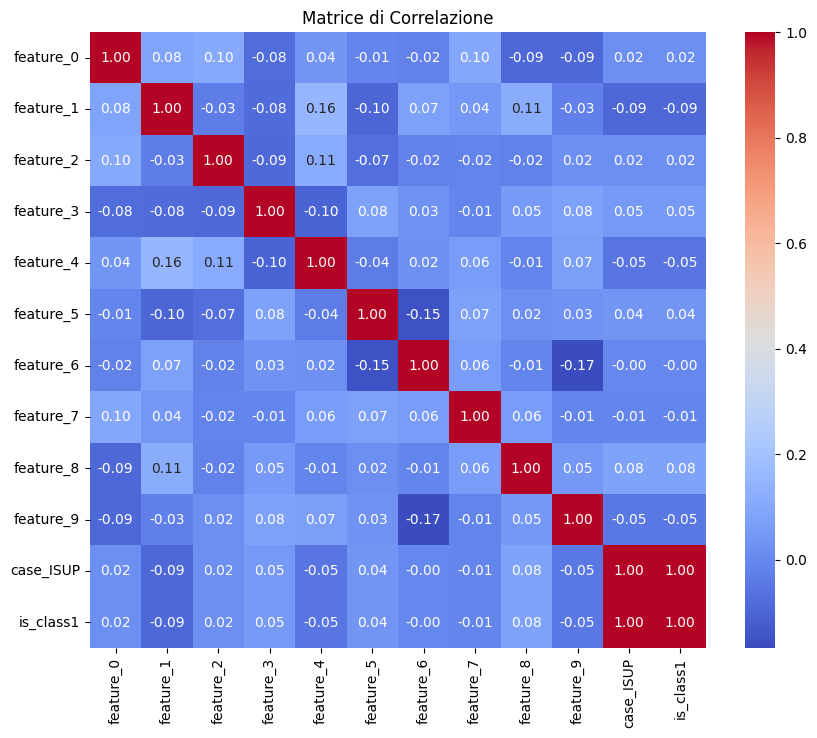

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(edited.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice di Correlazione")
plt.show()

In [34]:
print(edited.dtypes)

feature_0    float64
feature_1    float64
feature_2    float64
feature_3    float64
feature_4    float64
feature_5    float64
feature_6    float64
feature_7    float64
feature_8    float64
feature_9    float64
case_ISUP      int64
is_class1      int64
dtype: object


In [35]:
import pandas as pd
from scipy.stats import ttest_ind

# Supponendo che 'edited' sia il tuo DataFrame
# e che 'is_class1' sia la variabile categorica binaria

# Seleziona le colonne numeriche
numerical_features = edited.select_dtypes(include=['int64', 'float64']).columns.drop('is_class1')

# Crea due gruppi basati su 'is_class1'
group0 = edited[edited['is_class1'] == 0]
group1 = edited[edited['is_class1'] == 1]

# Esegui il t-test per ciascuna variabile numerica
results = []
for feature in numerical_features:
    stat, p_value = ttest_ind(group0[feature], group1[feature], equal_var=False)
    results.append({'Feature': feature, 'T-Statistic': stat, 'P-Value': p_value})

# Crea un DataFrame con i risultati
results_df = pd.DataFrame(results)

# Ordina i risultati per P-Value
results_df = results_df.sort_values(by='P-Value')

print(results_df)

      Feature  T-Statistic   P-Value
10  case_ISUP         -inf  0.000000
1   feature_1     1.477366  0.140883
8   feature_8    -1.284594  0.200174
4   feature_4     0.840311  0.401575
3   feature_3    -0.778139  0.437247
9   feature_9     0.755519  0.450710
5   feature_5    -0.575909  0.565214
2   feature_2    -0.258357  0.796352
0   feature_0    -0.235773  0.813808
7   feature_7     0.129555  0.897026
6   feature_6     0.068543  0.945410


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint
import pandas as pd

# --- STEP 1: Filtra ISUP 2 vs 3 ---
# The previous line filtering 'edited' is redundant and can be removed.
# edited = edited[edited['case_ISUP'].isin([2, 3])].copy() # Remove this line
# The line below was causing the error because 'full_dataset' was not defined.
# edited = full_dataset[full_dataset['case_ISUP'].isin([2, 3])].copy() # This line caused the error




# STEP 2: Feature + Target
X = edited.drop(columns=['case_ISUP', 'is_class1'])
y = edited['is_class1']



# TOLGO ALTA CORRELAZIONE E NAN
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X = X.drop(columns=to_drop)

X = X.fillna(X.mean())

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- STEP 3: RandomizedSearchCV con class_weight='balanced' ---
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',  # Cambia in 'recall' se preferisci ottimizzare il recall
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Addestramento
random_search.fit(X_train, y_train)

# Valutazione
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print(" Migliori iperparametri trovati:")
print(random_search.best_params_)

print("\n Metriche sul test set:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.3f}")

 Migliori iperparametri trovati:
{'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}

 Metriche sul test set:
Accuracy : 0.490
Precision: 0.407
Recall   : 0.550
F1 Score : 0.468


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/


Top 10 Feature per Random Forest (Tuned):
                                               Feature  Importance
88                  wavelet-LHL_firstorder_Entropy_t2w    0.012059
118  wavelet-LHH_gldm_LargeDependenceLowGrayLevelEm...    0.010691
106            wavelet-LHH_firstorder_10Percentile_t2w    0.010466
258                     wavelet-LHL_ngtdm_Busyness_adc    0.010297
170                    wavelet-HHH_firstorder_Mean_t2w    0.010156
343  wavelet-HHH_glszm_SizeZoneNonUniformityNormali...    0.010108
173                wavelet-HHH_firstorder_Skewness_t2w    0.009701
321                  wavelet-HHL_glcm_ClusterShade_adc    0.009498
298                    wavelet-HLH_firstorder_Mean_adc    0.009408
77              wavelet-LLH_glcm_ClusterProminence_t2w    0.009365


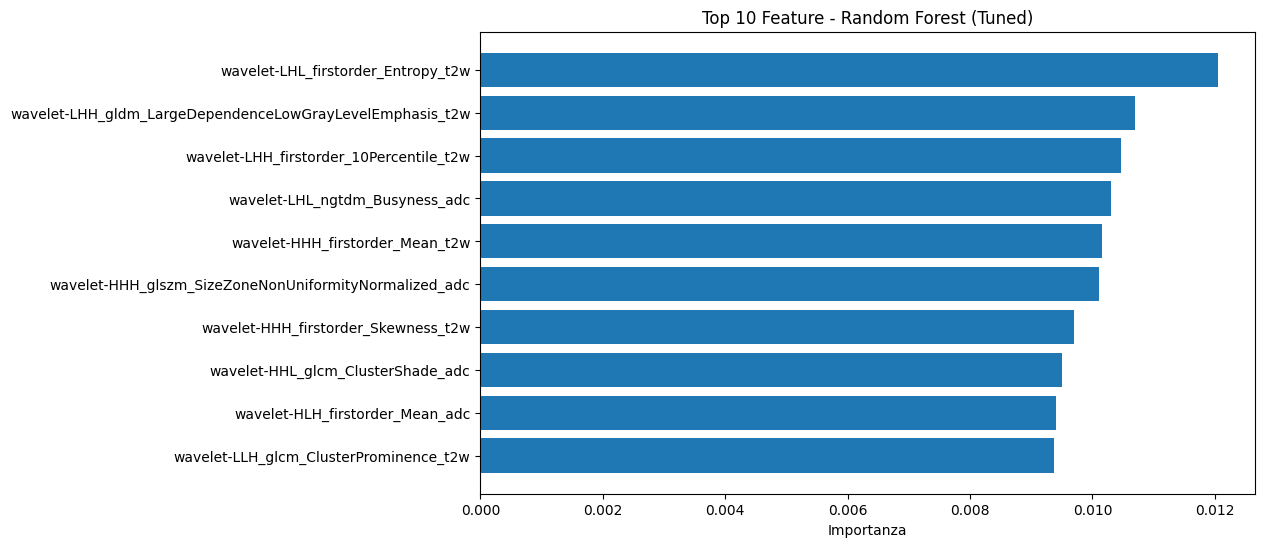

In [19]:
import matplotlib.pyplot as plt

# Ottieni le feature importance dal modello
importances = best_rf.feature_importances_
feature_names = X.columns

# Crea un DataFrame per ordinarle
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostra le top 10
print("\nTop 10 Feature per Random Forest (Tuned):")
print(feat_imp.head(10))

# Plot (opzionale)
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'][:10], feat_imp['Importance'][:10])
plt.xlabel("Importanza")
plt.title("Top 10 Feature - Random Forest (Tuned)")
plt.gca().invert_yaxis()
plt.show()


## RANDOM FOREST CON SMOTE (è peggio)

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint

# STEP 1: Filtro classi 2 vs 3
edited = edited[edited['case_ISUP'].isin([2, 3])].copy()
edited['is_class1'] = edited['case_ISUP'].map(lambda x: 1 if x == 3 else 0)

# STEP 2: X e y
X = edited.drop(columns=['case_ISUP', 'is_class1'])
y = edited['is_class1']

# Togli feature altamente correlate
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X = X.drop(columns=to_drop)

# Riempie NaN
X = X.fillna(X.mean())

# Train/test split PRIMA di SMOTE (SMOTE va solo sul train!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applica SMOTE SOLO al training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Tuning Random Forest
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit su dati aumentati
random_search.fit(X_train_res, y_train_res)

# Valutazione su test (non SMOTizzato)
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n📊 Migliori iperparametri trovati:")
print(random_search.best_params_)

print("\n🔍 Metriche sul test set (non oversampled):")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/


📊 Migliori iperparametri trovati:
{'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 93}

🔍 Metriche sul test set (non oversampled):
Accuracy : 0.535
Precision: 0.556
Recall   : 0.238
F1 Score : 0.333


## XGBOOST

In [21]:
!pip install xgboost

In [22]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=1,
    n_estimators=100
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.3f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:24:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
Accuracy: 0.488
Precision: 0.429
Recall: 0.143
F1 Score: 0.214


## LGBM

In [23]:
!pip install lightgbm

In [24]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_lgb):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_lgb):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgb):.3f}")


[LightGBM] [Info] Number of positive: 49, number of negative: 122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20497
[LightGBM] [Info] Number of data points in the train set: 171, number of used features: 354
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.286550 -> initscore=-0.912201
[LightGBM] [Info] Start training from score -0.912201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

## MLP

In [25]:
# Re-import delle librerie necessarie dopo il reset del kernel
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np

# Simulazione del dataset come prima (ISUP 2 vs 3)
np.random.seed(42)
simulated_data = pd.DataFrame(
    np.random.randn(500, 10),
    columns=[f'feature_{i}' for i in range(10)]
)
simulated_data['case_ISUP'] = np.random.choice([1, 2, 3, 4], size=500)

# Filtro e label
edited = simulated_data[simulated_data['case_ISUP'].isin([2, 3])].copy()
edited['is_class1'] = edited['case_ISUP'].map(lambda x: 1 if x == 3 else 0)

# Features e target


# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# MLP Classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

# Addestramento
mlp.fit(X_train, y_train)

# Predizione e metriche
y_pred_mlp = mlp.predict(X_test)
mlp_results = {
    'Model': 'MLP Neural Network',
    'Accuracy': accuracy_score(y_test, y_pred_mlp),
    'Precision': precision_score(y_test, y_pred_mlp),
    'Recall': recall_score(y_test, y_pred_mlp),
    'F1 Score': f1_score(y_test, y_pred_mlp)
}

pd.DataFrame([mlp_results])


,Model,Accuracy,Precision,Recall,F1 Score
0,MLP Neural Network,0.488372,0.428571,0.142857,0.214286


# AUMENTO NUMERO RIGHE


Per migliorare l’addestramento del modello, ho effettuato data augmentation sul training set. Ho generato nuove righe aggiungendo un piccolo rumore ai dati originali, in modo da simulare variazioni realistiche. Così ho triplicato la dimensione del training set facendo IL TRAINING-TEST SPLIT prima. L’etichetta è rimasta la stessa, e il test set non è mai stato toccato, quindi le valutazioni del modello sono affidabili e non affette da overfitting o data leakage.

In [44]:
# Train/test split PRIMA
from sklearn.model_selection import train_test_split

X = edited.drop(columns=['case_ISUP', 'is_class1'])
y = edited['is_class1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Augmenta SOLO X_train
augmented_list = []
num_copies = 3

for i in range(1, num_copies + 1):
    sampled = X_train.sample(frac=1.0, replace=True, random_state=42 + i)
    noise = np.random.normal(loc=0, scale=0.01 * i, size=sampled.shape)
    noisy = sampled + noise
    augmented_list.append(noisy)

X_train_aug = pd.concat([X_train] + augmented_list, ignore_index=True)
y_train_aug = pd.concat([y_train] * (num_copies + 1), ignore_index=True)


## Random forest df aumentato

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Standardizzazione
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)

# Random Forest base
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Spazio degli iperparametri
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit con i dati augmentati
random_search.fit(X_train_scaled, y_train_aug)

# Valutazione sul vero test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

# Stampa delle metriche
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Accuracy: 0.673469387755102
Precision: 0.6290322580645161
Recall: 0.8125
F1 Score: 0.7090909090909091


In [53]:
from sklearn.metrics import classification_report

# Predizioni sul test set
y_pred = best_rf.predict(X_test_scaled)

# Report completo per ciascuna classe
report = classification_report(y_test, y_pred, target_names=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])
print(report)


                   precision    recall  f1-score   support

Classe 0 (ISUP 2)       0.75      0.54      0.63       100
Classe 1 (ISUP 3)       0.63      0.81      0.71        96

         accuracy                           0.67       196
        macro avg       0.69      0.68      0.67       196
     weighted avg       0.69      0.67      0.67       196



Pro: Il modello è molto attento a non sottovalutare casi gravi
(pochi falsi negativi → pochi pazienti con ISUP 3 classificati come ISUP 2)

Contro: Alcuni pazienti con ISUP 2 verranno etichettati come ISUP 3
(falsi positivi → rischio di inviare pazienti a biopsie o trattamenti non necessari)

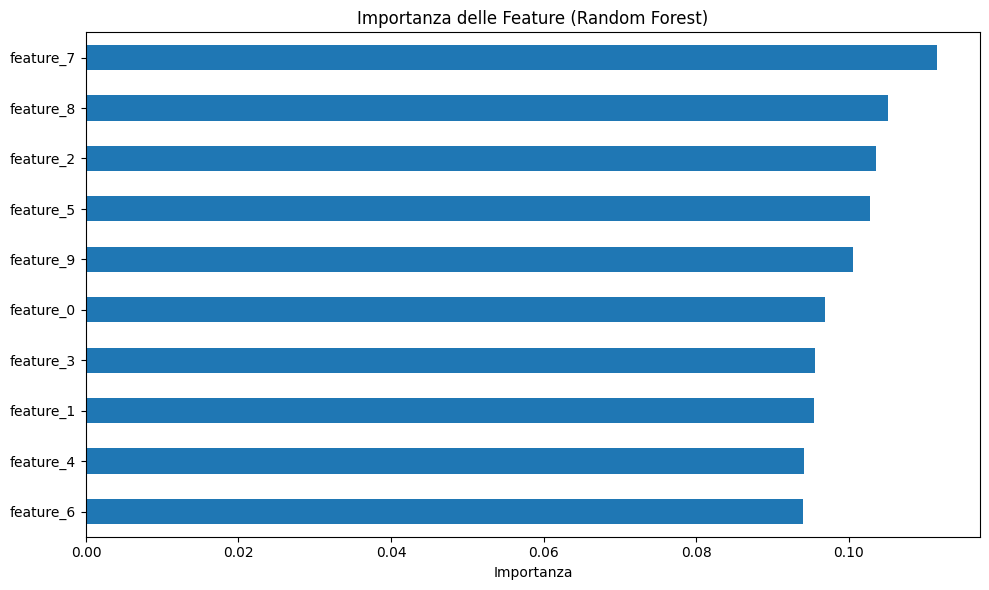

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Recupera i nomi delle feature
feature_names = X.columns

# Importanza dal modello
importances = best_rf.feature_importances_

# Visualizzazione
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh')
plt.title("Importanza delle Feature (Random Forest)")
plt.xlabel("Importanza")
plt.tight_layout()
plt.show()


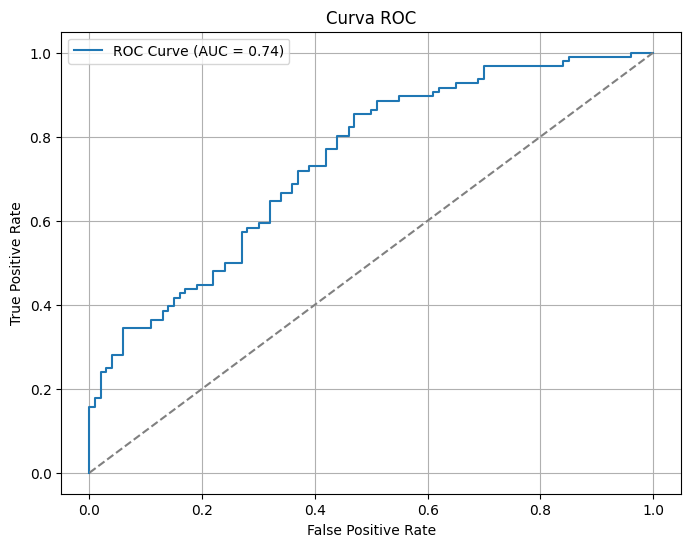

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilità predette (non le classi)
y_proba = best_rf.predict_proba(X_test_scaled)[:, 1]  # solo la colonna positiva

# Curve ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

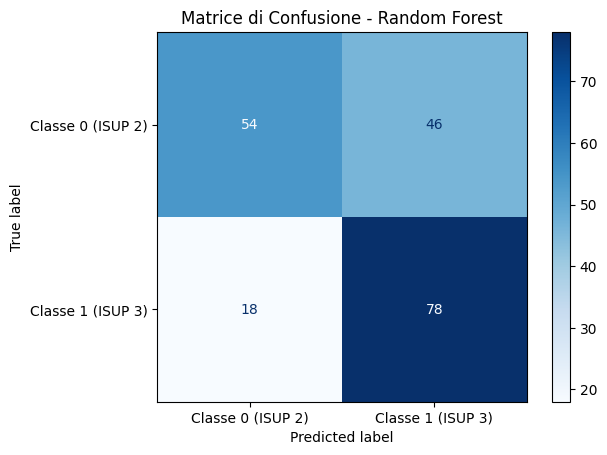

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predizioni sul test set
y_pred = best_rf.predict(X_test_scaled)

# Calcolo della matrice di confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])

# Visualizzazione
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice di Confusione - Random Forest")
plt.grid(False)
plt.show()

## Xgboost df aumentato

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_scaled, y_train_aug)
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

print("Best XGBoost Parameters:", random_search_xgb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Parameters: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.5561224489795918
Precision: 0.5248618784530387
Recall: 0.9895833333333334
F1 Score: 0.6859205776173285


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:41:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [58]:
from sklearn.metrics import classification_report

# Predizioni XGBoost
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Report completo
report_xgb = classification_report(y_test, y_pred_xgb, target_names=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])
print(report_xgb)



                   precision    recall  f1-score   support

Classe 0 (ISUP 2)       0.93      0.14      0.24       100
Classe 1 (ISUP 3)       0.52      0.99      0.69        96

         accuracy                           0.56       196
        macro avg       0.73      0.56      0.46       196
     weighted avg       0.73      0.56      0.46       196



<Figure size 600x600 with 0 Axes>

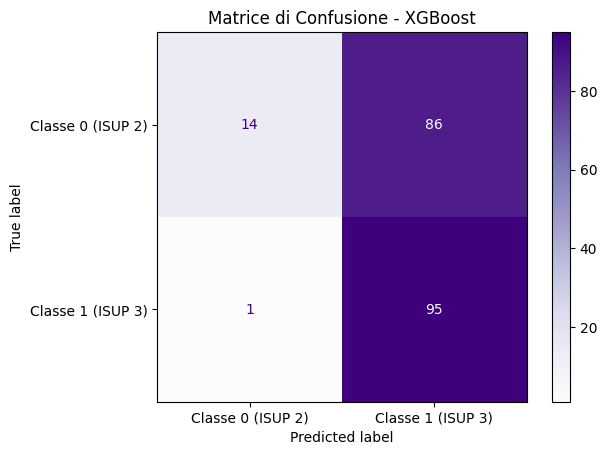

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predizioni XGBoost
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Matrice di confusione
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])

# Visualizzazione
plt.figure(figsize=(6, 6))
disp_xgb.plot(cmap="Purples", values_format="d")
plt.title("Matrice di Confusione - XGBoost")
plt.grid(False)
plt.show()


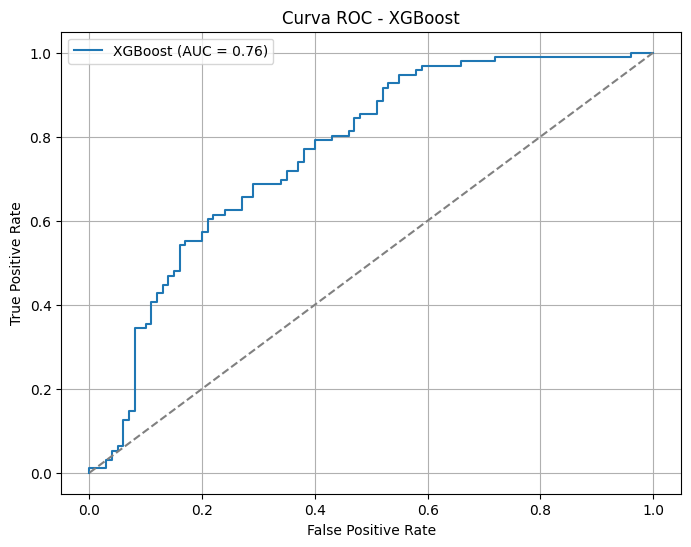

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilità previste
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]  # Probabilità della classe 1

# Curve ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


## MLP df aumentato

In [61]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=500, random_state=42)

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

random_search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist_mlp,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_mlp.fit(X_train_scaled, y_train_aug)
best_mlp = random_search_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

print("Best MLP Parameters:", random_search_mlp.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Precision:", precision_score(y_test, y_pred_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))
print("F1 Score:", f1_score(y_test, y_pred_mlp))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MLP Parameters: {'solver': 'adam', 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}
Accuracy: 0.6530612244897959
Precision: 0.6111111111111112
Recall: 0.8020833333333334
F1 Score: 0.6936936936936937


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [62]:
from sklearn.metrics import classification_report

# Predizioni
y_pred_mlp = best_mlp.predict(X_test_scaled)

# Report dettagliato
report_mlp = classification_report(y_test, y_pred_mlp, target_names=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])
print(report_mlp)


                   precision    recall  f1-score   support

Classe 0 (ISUP 2)       0.73      0.51      0.60       100
Classe 1 (ISUP 3)       0.61      0.80      0.69        96

         accuracy                           0.65       196
        macro avg       0.67      0.66      0.65       196
     weighted avg       0.67      0.65      0.65       196



<Figure size 600x600 with 0 Axes>

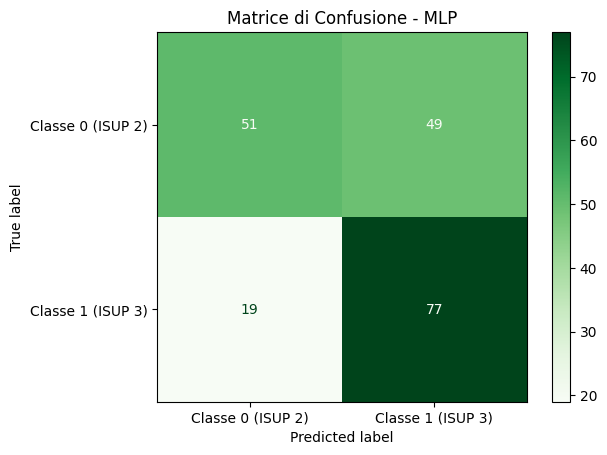

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matrice di confusione
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=["Classe 0 (ISUP 2)", "Classe 1 (ISUP 3)"])

# Visualizzazione
plt.figure(figsize=(6, 6))
disp_mlp.plot(cmap="Greens", values_format="d")
plt.title("Matrice di Confusione - MLP")
plt.grid(False)
plt.show()


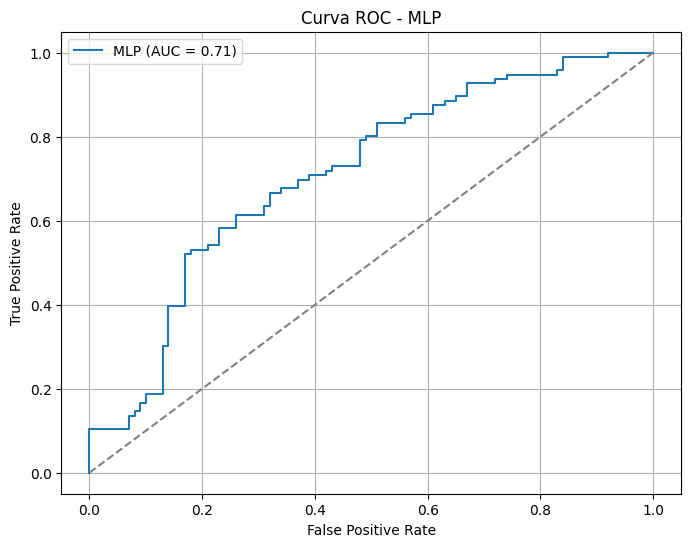

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilità predette (classe positiva)
y_proba_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
auc_mlp = roc_auc_score(y_test, y_proba_mlp)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - MLP')
plt.legend()
plt.grid(True)
plt.show()


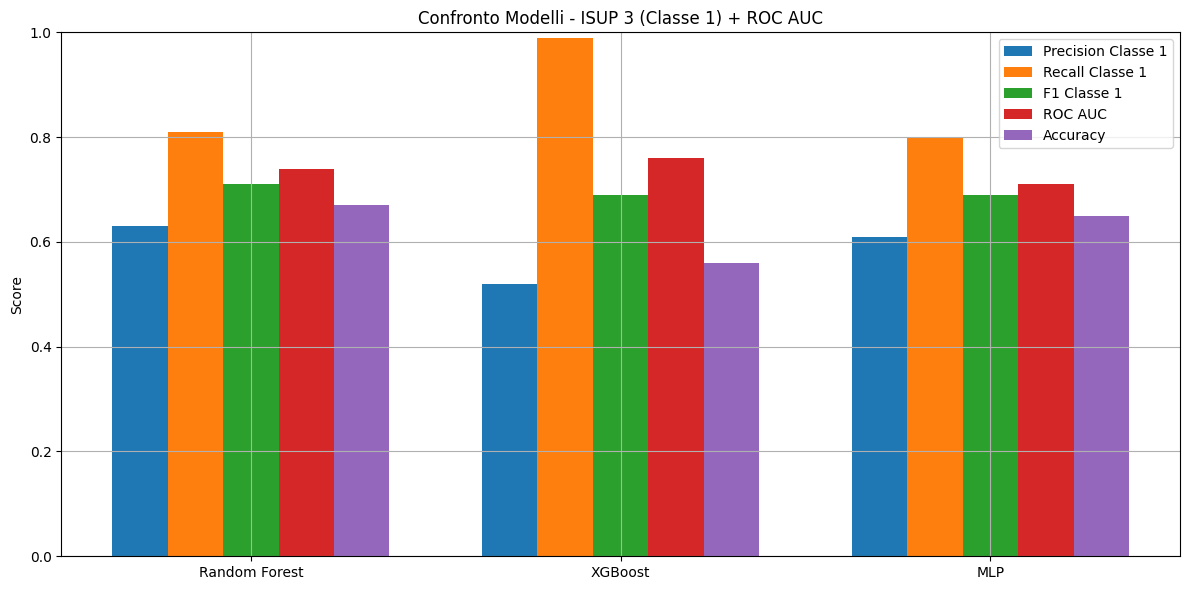

In [65]:
# Creo un confronto a partire dai valori riportati per RF, XGBoost e MLP

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Modello: RF, XGBoost, MLP
data = {
    'Modello': ['Random Forest', 'XGBoost', 'MLP'],
    'Precision Classe 0': [0.75, 0.93, 0.73],
    'Recall Classe 0': [0.54, 0.14, 0.51],
    'F1 Classe 0': [0.63, 0.24, 0.60],
    'Precision Classe 1': [0.63, 0.52, 0.61],
    'Recall Classe 1': [0.81, 0.99, 0.80],
    'F1 Classe 1': [0.71, 0.69, 0.69],
    'Accuracy': [0.67, 0.56, 0.65],
    'ROC AUC': [0.74, 0.76, 0.71]
}

df = pd.DataFrame(data)

# Plotting (focus su Classe 1 + ROC)
metrics = ['Precision Classe 1', 'Recall Classe 1', 'F1 Classe 1', 'ROC AUC', 'Accuracy']
x = np.arange(len(df['Modello']))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, df[metric], width, label=metric)

ax.set_ylabel('Score')
ax.set_title('Confronto Modelli - ISUP 3 (Classe 1) + ROC AUC')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(df['Modello'])
ax.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
